# ***Implementation of DINOv2-style Self-Supervised Learning Plastic Object Detection from Seashore using YOLOv10 backbone***

# Setup

In [1]:
!pip -q install ultralytics timm tqdm pillow 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 4.7 MB/s eta 0:00:00


In [2]:
import os, json, yaml, math, gc, random, shutil, contextlib
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.auto import tqdm
from ultralytics import YOLO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print("Device:", device, "| torch", torch.__version__)

def autocast_ctx():
    return torch.autocast(device_type="cuda", enabled=True) if device=="cuda" else contextlib.nullcontext()

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Device: cuda | torch 2.6.0+cu124


# Dataset Path

In [3]:

BASE  = Path("/kaggle/input/plastic-coco/plastic_coco")
WORK  = Path("/kaggle/working/plastic_coco_ssl_yolov10_dinov2")
SPLIT = WORK / "yolo_split"
DATA  = WORK / "data_plastic_coco.yaml"
SSL_W = WORK / "backbone_ssl_v10_dinov2.pt"   
WORK.mkdir(parents=True, exist_ok=True)

# COCO -> YOLO conversion (once)

In [4]:
def coco2yolo(b, w, h):
    x, y, bw, bh = b
    return (x + bw / 2) / w, (y + bh / 2) / h, bw / w, bh / h

def convert(split, img_dir, ann_json):
    out_im, out_lb = SPLIT / split / "images", SPLIT / split / "labels"
    out_im.mkdir(parents=True, exist_ok=True)
    out_lb.mkdir(parents=True, exist_ok=True)

    coco = json.load(open(ann_json))
    id2 = {im["id"]: im for im in coco["images"]}

    # write labels
    for ann in coco["annotations"]:
        im = id2[ann["image_id"]]
        yb = coco2yolo(ann["bbox"], im["width"], im["height"])
        with open(out_lb / f"{Path(im['file_name']).stem}.txt", "a") as f:
            f.write(f"{ann['category_id']-1} " + " ".join(f"{v:.6f}" for v in yb) + "\n")

    # copy images
    for im in coco["images"]:
        src = Path(img_dir) / im["file_name"]
        dst = out_im / im["file_name"]
        if src.exists():
            shutil.copy(src, dst)
        else:
            print(f"Missing image: {src}")

# ========================
# Run Conversion
# ========================
if not DATA.exists():
    print("➤ Converting COCO → YOLO …")

    convert("train", BASE / "images" / "train", BASE / "annotation" / "train.json")
    convert("valid", BASE / "images" / "val",   BASE / "annotation" / "val.json")
    convert("test",  BASE / "images" / "test",  BASE / "annotation" / "test.json")

    # class names
    categories = json.load(open(BASE / "annotation" / "train.json"))["categories"]
    names = [c["name"] for c in sorted(categories, key=lambda x: x["id"])]

    DATA.write_text(yaml.dump({
        "path": str(SPLIT),
        "train": "train/images",
        "val": "valid/images",
        "test": "test/images",
        "nc": len(names),
        "names": names
    }))
    print("✓ YOLO split ready at", SPLIT)
else:
    print("YOLO split already exists")
    

➤ Converting COCO → YOLO …
✓ YOLO split ready at /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split


# Multi-crop Dataset (DINOv2-style: 2 global + 8 local)

In [5]:

class MultiCropDINO(Dataset):
    SUPP=('*.jpg','*.jpeg','*.png','*.JPG','*.JPEG','*.PNG')
    def __init__(self, roots, g_size=224, l_size=96, n_local=8):
        self.files=[p for r in roots for s in self.SUPP for p in Path(r).rglob(s)]
        if not self.files: raise RuntimeError("No images found for SSL.")
        self.g1 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.GaussianBlur(1, 0.1),
            transforms.ToTensor()
        ])
        self.g2 = transforms.Compose([
            transforms.RandomResizedCrop(g_size, scale=(0.4, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.local = transforms.Compose([
            transforms.RandomResizedCrop(l_size, scale=(0.05, 0.4), interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.Resize(g_size, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(0.4,0.4,0.4,0.1),
            transforms.RandomGrayscale(0.2),
            transforms.ToTensor()
        ])
        self.n_local = n_local
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        crops=[self.g1(img), self.g2(img)]
        crops.extend([self.local(img) for _ in range(self.n_local)])
        return crops

# Build YOLOv10s model and grab backbone (no fallback) 
# Robust encoder that handles different backbone return types/shapes

In [6]:
detector = YOLO("yolov10s.yaml")   # requires Ultralytics with YOLOv10 assets
model = detector.model

student_bb = model.model[0].to(device)
teacher_bb = YOLO("yolov10s.yaml").model.model[0].to(device)
teacher_bb.load_state_dict(student_bb.state_dict())
for p in teacher_bb.parameters(): p.requires_grad=False

def _pick_last_feat(out):
    """Return a tensor representing the deepest feature map/vector from backbone output."""
    if isinstance(out, (list, tuple)) and len(out) > 0:
        t = out[-1]
    elif isinstance(out, dict) and len(out) > 0:
        t = list(out.values())[-1]
    else:
        t = out
    if not torch.is_tensor(t):
        # some modules could return nested structures
        if isinstance(t, (list, tuple)) and len(t) > 0 and torch.is_tensor(t[-1]):
            t = t[-1]
        elif isinstance(t, dict) and len(t) > 0 and torch.is_tensor(list(t.values())[-1]):
            t = list(t.values())[-1]
        else:
            raise RuntimeError("Backbone output type not understood.")
    return t

class BackboneEncoder(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        # shape adapt: [B,C,H,W] → GAP; [B,C,T] → mean over T; [B,C] → as-is; else flatten
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

student_enc = BackboneEncoder(student_bb).to(device)
teacher_enc = BackboneEncoder(teacher_bb).to(device)

with torch.no_grad():
    dmy = torch.zeros(1,3,224,224,device=device)
    feat_dim = student_enc(dmy).shape[1]
print("Backbone feature dim:", feat_dim)

Backbone feature dim: 32


# DINOv2-style Heads and Loss

In [7]:
OUT_DIM = 256

def projector(in_dim, hid=2048, out=OUT_DIM):
    return nn.Sequential(
        nn.Linear(in_dim, hid), nn.GELU(), nn.BatchNorm1d(hid),
        nn.Linear(hid, out)
    )

student_head = projector(feat_dim).to(device)
teacher_head = projector(feat_dim).to(device)
teacher_head.load_state_dict(student_head.state_dict())
for p in teacher_head.parameters(): p.requires_grad=False

class DINOLoss(nn.Module):
    def __init__(self, out_dim, n_global=2,
                 teacher_temp_warm=0.04, teacher_temp=0.07,
                 warmup_frac=0.1, total_epochs=100,
                 center_m=0.9, student_temp=0.1):
        super().__init__()
        self.n_global=n_global
        self.t_warm, self.t_final = teacher_temp_warm, teacher_temp
        self.warmup_frac, self.T = warmup_frac, total_epochs
        self.cm = center_m
        self.student_temp = student_temp
        self.register_buffer("center", torch.zeros(1,out_dim))
    def teacher_T(self, epoch):
        if epoch < self.warmup_frac*self.T:
            a=epoch/(self.warmup_frac*self.T)
            return self.t_warm + (self.t_final-self.t_warm)*a
        return self.t_final
    def forward(self, s_out, t_out, epoch):
        Tt = self.teacher_T(epoch)
        s_logits = [s/self.student_temp for s in s_out]
        t_probs  = [F.softmax((t - self.center)/Tt, dim=-1).detach() for t in t_out]
        loss=0; cnt=0
        for iq, q in enumerate(t_probs):
            for v, s in enumerate(s_logits):
                if v==iq:  # skip same-index global view
                    continue
                loss += -(q * F.log_softmax(s, dim=-1)).sum(1).mean()
                cnt += 1
        loss /= max(cnt,1)
        with torch.no_grad():
            batch_center = torch.cat(t_out, 0).mean(0, keepdim=True)
            self.center = self.center*self.cm + (1-self.cm)*batch_center
        return loss


# DINOv2-style SSL pretraining

In [8]:
EPOCHS     = 50       # increase to 50–100 for stronger transfer
BATCH      = 16
ACCUM      = 2
LR         = 5e-4
WD         = 0.05
EMA0       = 0.996
N_LOCAL    = 8
NUM_WORKERS= 0

train_losses = []

if SSL_W.exists():
    print("✓ SSL backbone cache found – skipping DINOv2-style pretrain")
else:
    print("\n DINOv2-style pretraining on YOLOv10 backbone …")
    ds = MultiCropDINO([SPLIT/"train/images", SPLIT/"valid/images", SPLIT/"test/images"],
                       g_size=224, l_size=96, n_local=N_LOCAL)
    dl = DataLoader(ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS,
                    pin_memory=True, drop_last=True)

    params = list(student_enc.parameters()) + list(student_head.parameters())
    opt = torch.optim.AdamW(params, lr=LR, weight_decay=WD)
    lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))

    loss_fn = DINOLoss(OUT_DIM, n_global=2,
                       teacher_temp_warm=0.04, teacher_temp=0.07,
                       warmup_frac=0.1, total_epochs=EPOCHS,
                       center_m=0.9, student_temp=0.1).to(device)

    steps_per_epoch = len(dl)
    total_steps = steps_per_epoch * EPOCHS
    gstep = 0

    student_enc.train(); student_head.train()
    for ep in range(EPOCHS):
        ep_loss=0.0; accum=0
        opt.zero_grad(set_to_none=True)
        for views in tqdm(dl, desc=f"SSL Ep {ep+1}/{EPOCHS}", leave=False):
            views = [v.to(device) for v in views]  # [g1, g2, l1..lN]
            with autocast_ctx():
                s_feats = [student_enc(v) for v in views]
                s_outs  = [student_head(z) for z in s_feats]              # all crops
                with torch.no_grad():
                    t_feats = [teacher_enc(v) for v in views[:2]]         # globals only
                    t_outs  = [teacher_head(z) for z in t_feats]
                loss = loss_fn(s_outs, t_outs, epoch=ep) / ACCUM

            scaler.scale(loss).backward()
            accum += 1
            if accum == ACCUM:
                scaler.unscale_(opt)
                nn.utils.clip_grad_norm_(params, 3.0)
                scaler.step(opt); scaler.update()
                opt.zero_grad(set_to_none=True)
                accum = 0

                # EMA update (cosine momentum) for teacher backbone + head
                m = 1 - (1-EMA0) * (math.cos(math.pi*gstep/total_steps)+1)/2
                with torch.no_grad():
                    for ps, pt in zip(student_bb.parameters(), teacher_bb.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                    for ps, pt in zip(student_head.parameters(), teacher_head.parameters()):
                        pt.data.mul_(m).add_(ps.data, alpha=1-m)
                gstep += 1

            ep_loss += loss.item() * ACCUM

        lr_sched.step()
        avg_loss = ep_loss / steps_per_epoch
        train_losses.append(avg_loss)
        print(f"SSL Epoch {ep+1:02d}: loss={ep_loss/steps_per_epoch:.4f}")

    SSL_W.parent.mkdir(parents=True, exist_ok=True)
    torch.save(student_bb.state_dict(), SSL_W)
    del ds, dl
    gc.collect()
    print("✓ Saved SSL YOLOv10 backbone →", SSL_W)



 DINOv2-style pretraining on YOLOv10 backbone …


/tmp/ipykernel_19/1132428671.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))


SSL Ep 1/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 01: loss=5.6969


SSL Ep 2/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 02: loss=4.2397


SSL Ep 3/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 03: loss=5.5152


SSL Ep 4/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 04: loss=7.7830


SSL Ep 5/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 05: loss=8.2722


SSL Ep 6/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 06: loss=7.4944


SSL Ep 7/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 07: loss=6.9456


SSL Ep 8/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 08: loss=6.2752


SSL Ep 9/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 09: loss=6.4769


SSL Ep 10/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 10: loss=5.9538


SSL Ep 11/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 11: loss=6.1071


SSL Ep 12/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 12: loss=5.9852


SSL Ep 13/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 13: loss=5.8524


SSL Ep 14/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 14: loss=5.7904


SSL Ep 15/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 15: loss=5.8081


SSL Ep 16/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 16: loss=5.6162


SSL Ep 17/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 17: loss=5.6582


SSL Ep 18/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 18: loss=5.8894


SSL Ep 19/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 19: loss=5.6884


SSL Ep 20/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 20: loss=5.5083


SSL Ep 21/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 21: loss=5.6538


SSL Ep 22/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 22: loss=5.5414


SSL Ep 23/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 23: loss=5.4877


SSL Ep 24/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 24: loss=5.4107


SSL Ep 25/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 25: loss=5.3924


SSL Ep 26/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 26: loss=5.3938


SSL Ep 27/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 27: loss=5.4146


SSL Ep 28/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 28: loss=5.3940


SSL Ep 29/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 29: loss=5.3960


SSL Ep 30/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 30: loss=5.3944


SSL Ep 31/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 31: loss=5.3902


SSL Ep 32/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 32: loss=5.3938


SSL Ep 33/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 33: loss=5.3975


SSL Ep 34/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 34: loss=5.3930


SSL Ep 35/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 35: loss=5.3957


SSL Ep 36/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 36: loss=5.3907


SSL Ep 37/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 37: loss=5.3957


SSL Ep 38/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 38: loss=5.3923


SSL Ep 39/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 39: loss=5.3884


SSL Ep 40/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 40: loss=5.3910


SSL Ep 41/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 41: loss=5.3921


SSL Ep 42/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 42: loss=5.3905


SSL Ep 43/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 43: loss=5.3898


SSL Ep 44/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 44: loss=5.3939


SSL Ep 45/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 45: loss=5.3913


SSL Ep 46/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 46: loss=5.3915


SSL Ep 47/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 47: loss=5.3932


SSL Ep 48/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 48: loss=5.3871


SSL Ep 49/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 49: loss=5.3962


SSL Ep 50/50:   0%|          | 0/231 [00:00<?, ?it/s]

SSL Epoch 50: loss=5.3935
✓ Saved SSL YOLOv10 backbone → /kaggle/working/plastic_coco_ssl_yolov10_dinov2/backbone_ssl_v10_dinov2.pt


# Loss Curve

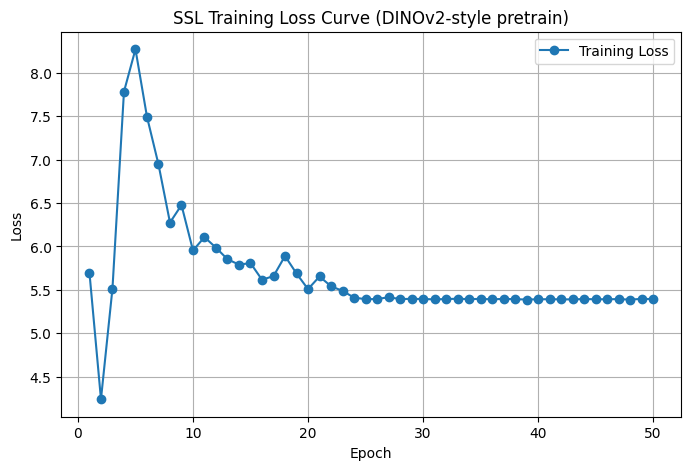

In [9]:
# =============================
# Plot training loss curves
# =============================

plt.figure(figsize=(8,5))
plt.plot(range(1, EPOCHS+1), train_losses, marker="o", label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("SSL Training Loss Curve (DINOv2-style pretrain)")
plt.legend()
plt.grid(True)
plt.show()

#  Detector fine-tuning (YOLOv10s, init with SSL backbone)

In [10]:
det = YOLO("yolov10s.yaml")  
missing, unexpected = det.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
print("Loaded backbone with missing:", len(missing), " unexpected:", len(unexpected))

det.train(
    data=str(DATA),
    epochs=50,                   
    imgsz=640,
    batch=8,
    optimizer="AdamW",            
    lr0=5e-4,                     
    lrf=1e-5,
    weight_decay=0.05,
    cos_lr=True,                  
    mosaic=1.0,
    mixup=0.2,                    
    copy_paste=0.2,               
    auto_augment="randaugment",
    close_mosaic=15,              
    dropout=0.1,                  
    patience=30,
    save_period=5,
    device=0 if device=="cuda" else "cpu",
    project=str(WORK),
    name="ssl_yolov10s_dinov2",
    verbose=True,
)


Loaded backbone with missing: 0  unexpected: 0
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.2, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/plastic_coco_ssl_yolov10_dinov2/data_plastic_coco.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.1, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0005, lrf=1e-05, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov10s.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=ssl_yolov10s_dinov2, nbs=64, nms=False, opset=None,

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1     36096  ultralytics.nn.modules.block.SCDown          [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1    137728  ultralytics

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4426.1±967.5 MB/s, size: 776.5 KB)


train: Scanning /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/train/labels... 2223 images, 3 backgrounds, 0 corrupt: 100%|██████████| 2226/2226 [00:17<00:00, 130.61it/s]

train: New cache created: /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1330.2±968.0 MB/s, size: 694.7 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/valid/labels... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:05<00:00, 144.39it/s]

val: New cache created: /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/valid/labels.cache


Plotting labels to /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 99 weight(decay=0.0), 112 weight(decay=0.05), 111 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.47G      8.412      7.591      3.633        132        640: 100%|██████████| 279/279 [01:14<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.23it/s]


                   all        742      23015     0.0864     0.0629     0.0208    0.00517

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      6.05G      6.965      5.296      2.585        173        640: 100%|██████████| 279/279 [01:11<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


                   all        742      23015      0.265      0.165      0.114     0.0329

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50       6.1G      6.357       4.75      2.448         88        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.80it/s]


                   all        742      23015      0.305      0.211      0.158     0.0479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      6.14G      6.011       4.56       2.37        274        640: 100%|██████████| 279/279 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


                   all        742      23015      0.333      0.228      0.166     0.0499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      6.18G      5.827      4.379      2.327        233        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


                   all        742      23015      0.339      0.245      0.197     0.0629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.23G      5.696      4.284      2.295         97        640: 100%|██████████| 279/279 [01:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.73it/s]


                   all        742      23015      0.321      0.257      0.174     0.0572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.25G      5.526      4.185      2.253         61        640: 100%|██████████| 279/279 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.69it/s]


                   all        742      23015      0.376      0.273      0.225     0.0771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.32G      5.462      4.137      2.234        158        640: 100%|██████████| 279/279 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.68it/s]


                   all        742      23015      0.371      0.278      0.232     0.0794

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      6.37G      5.401      4.067      2.236        105        640: 100%|██████████| 279/279 [01:10<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


                   all        742      23015      0.366      0.284      0.234     0.0823

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      6.41G      5.299      3.992      2.206        157        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


                   all        742      23015      0.387      0.286      0.245     0.0915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      6.46G       5.26      3.997      2.206        412        640: 100%|██████████| 279/279 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.68it/s]


                   all        742      23015      0.388      0.294       0.25     0.0916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       6.5G      5.196      3.966      2.193        124        640: 100%|██████████| 279/279 [01:10<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


                   all        742      23015      0.397      0.283      0.249     0.0882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      6.55G      5.162      3.911      2.165        168        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.73it/s]


                   all        742      23015      0.399      0.299      0.258     0.0931

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      6.59G      5.064      3.839      2.163         63        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.70it/s]


                   all        742      23015      0.403      0.303      0.264     0.0981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      6.62G      5.072       3.83      2.164         66        640: 100%|██████████| 279/279 [01:10<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


                   all        742      23015      0.397      0.305      0.266        0.1

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      6.68G      5.034      3.842      2.156         93        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.73it/s]


                   all        742      23015      0.403      0.317      0.274      0.104

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      6.73G      5.012      3.802      2.146         96        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.77it/s]


                   all        742      23015      0.415      0.317      0.283      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      6.78G      4.954      3.746       2.14        154        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.69it/s]


                   all        742      23015      0.416      0.324      0.284      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      6.82G      4.959      3.746      2.143         82        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


                   all        742      23015      0.412      0.321      0.286      0.106

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      6.87G      4.941      3.702       2.13        158        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


                   all        742      23015      0.416       0.32      0.286      0.111

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      6.91G      4.896      3.664      2.117         31        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


                   all        742      23015       0.43      0.325      0.294      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      6.96G      4.857      3.699      2.118        182        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.80it/s]


                   all        742      23015      0.425      0.323      0.291      0.113

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      6.98G      4.851      3.664      2.106         27        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.77it/s]


                   all        742      23015       0.42       0.33      0.294      0.114

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      7.05G      4.843      3.658      2.116        261        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.80it/s]


                   all        742      23015      0.426       0.33      0.297      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      7.09G      4.848      3.642      2.114         50        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


                   all        742      23015      0.435      0.331      0.299      0.116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      7.83G      4.797      3.625      2.117         91        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


                   all        742      23015      0.428       0.33      0.299      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      7.87G      4.793      3.591        2.1         28        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


                   all        742      23015      0.426      0.325      0.298      0.115

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      7.92G      4.766      3.575      2.102        323        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.80it/s]


                   all        742      23015      0.432      0.338      0.306       0.12

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      7.96G      4.747      3.617      2.097          9        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.60it/s]


                   all        742      23015      0.428      0.338      0.305      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.85G      4.753      3.561      2.089         53        640: 100%|██████████| 279/279 [01:10<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.79it/s]


                   all        742      23015      0.453      0.338      0.314      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.85G      4.723      3.542      2.085         44        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.57it/s]


                   all        742      23015      0.441      0.336       0.31      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.85G      4.729      3.527      2.089        121        640: 100%|██████████| 279/279 [01:10<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.84it/s]


                   all        742      23015      0.442      0.339      0.312      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.44G       4.69      3.519      2.088         68        640: 100%|██████████| 279/279 [01:09<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.61it/s]


                   all        742      23015      0.438      0.344      0.311      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.44G      4.661      3.453      2.083         66        640: 100%|██████████| 279/279 [01:10<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.82it/s]


                   all        742      23015      0.451      0.342      0.317      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.45G      4.675      3.515      2.084         51        640: 100%|██████████| 279/279 [01:09<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.58it/s]


                   all        742      23015      0.452      0.348       0.32      0.128
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.49G      4.461      3.509       2.05         74        640: 100%|██████████| 279/279 [01:07<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.76it/s]


                   all        742      23015      0.454      0.344      0.318      0.128

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.54G      4.441      3.394      2.034         60        640: 100%|██████████| 279/279 [01:07<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.75it/s]


                   all        742      23015      0.456      0.347      0.324      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.59G      4.442      3.369      2.039         24        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


                   all        742      23015       0.46      0.346      0.326      0.131

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.61G      4.425      3.349      2.036         92        640: 100%|██████████| 279/279 [01:07<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.77it/s]


                   all        742      23015      0.463      0.347       0.33      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.68G       4.41      3.327      2.031         72        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:09<00:00,  5.22it/s]


                   all        742      23015      0.461      0.348      0.329      0.132

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.73G      4.404      3.308      2.033         18        640: 100%|██████████| 279/279 [01:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.71it/s]


                   all        742      23015      0.461       0.35       0.33      0.133

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.77G      4.403      3.318      2.033         90        640: 100%|██████████| 279/279 [01:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


                   all        742      23015      0.458      0.349       0.33      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.81G      4.384      3.316      2.034         27        640: 100%|██████████| 279/279 [01:07<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.81it/s]


                   all        742      23015      0.465      0.351      0.331      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.86G      4.382      3.301      2.027         39        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.83it/s]


                   all        742      23015      0.465       0.35      0.333      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50       4.9G      4.389      3.302      2.031         12        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.49it/s]


                   all        742      23015      0.461      0.352      0.333      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.95G      4.378      3.299       2.03        152        640: 100%|██████████| 279/279 [01:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.78it/s]


                   all        742      23015      0.462       0.35      0.332      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.98G      4.364      3.299      2.023         23        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.77it/s]


                   all        742      23015      0.463      0.352      0.334      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.04G      4.382      3.308      2.027         12        640: 100%|██████████| 279/279 [01:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.52it/s]


                   all        742      23015      0.465       0.35      0.333      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.09G      4.372      3.279      2.035         43        640: 100%|██████████| 279/279 [01:07<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


                   all        742      23015      0.464      0.352      0.333      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.13G      4.358      3.284      2.033         93        640: 100%|██████████| 279/279 [01:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:08<00:00,  5.72it/s]


                   all        742      23015      0.463      0.351      0.334      0.136

50 epochs completed in 1.092 hours.
Optimizer stripped from /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/last.pt, 16.5MB
Optimizer stripped from /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/best.pt, 16.5MB

Validating /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2/weights/best.pt...
Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:11<00:00,  4.00it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.462      0.352      0.334      0.136
Speed: 0.1ms preprocess, 4.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c1cdc717650>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

# Evaluate and visualize one image

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3709.6±1123.7 MB/s, size: 513.2 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:11<00:00,  8.11it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.463      0.352      0.335      0.136
Speed: 0.3ms preprocess, 5.7ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val

Validation metrics
 Precision (mP) : 0.4627
 Recall    (mR) : 0.3516
 mAP@0.50      : 0.3348
 mAP@0.50-0.95 : 0.1360


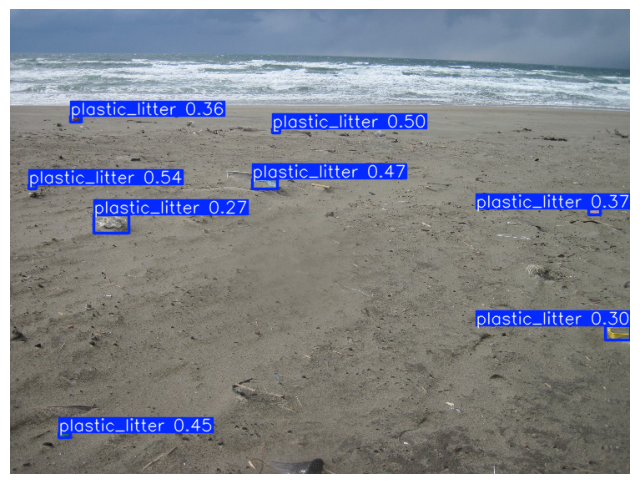

In [11]:
best_pt = WORK / "ssl_yolov10s_dinov2" / "weights" / "best.pt"
model_det = YOLO(str(best_pt))

results = model_det.val(data=str(DATA),
                        imgsz=640,
                        batch=8,
                        device=0 if device=="cuda" else "cpu")

try:
    mp, mr, map50, map5095 = results.mean_results()
except Exception:
    mp, mr = float(results.box.mp), float(results.box.mr)
    map50, map5095 = float(results.box.map50), float(results.box.map)

print("\nValidation metrics")
print(f" Precision (mP) : {mp:.4f}")
print(f" Recall    (mR) : {mr:.4f}")
print(f" mAP@0.50      : {map50:.4f}")
print(f" mAP@0.50-0.95 : {map5095:.4f}")

# visualize a random test image
test_imgs = list((SPLIT/"test/images").glob("*.*"))
if test_imgs:
    img_path = random.choice(test_imgs)
    pred = model_det.predict(source=str(img_path),
                             imgsz=640,
                             conf=0.25,
                             device=0 if device=="cuda" else "cpu",
                             verbose=False)[0]
    plt.figure(figsize=(8,8))
    plt.imshow(pred.plot()[:, :, ::-1])  # BGR->RGB
    plt.axis("off")
    plt.show()
else:
    print("No test images found for visualization.")

# PCA of SSL-pretrained YOLOv10 backbone features (robust encoder)

PCA Feature matrix: (1000, 32)


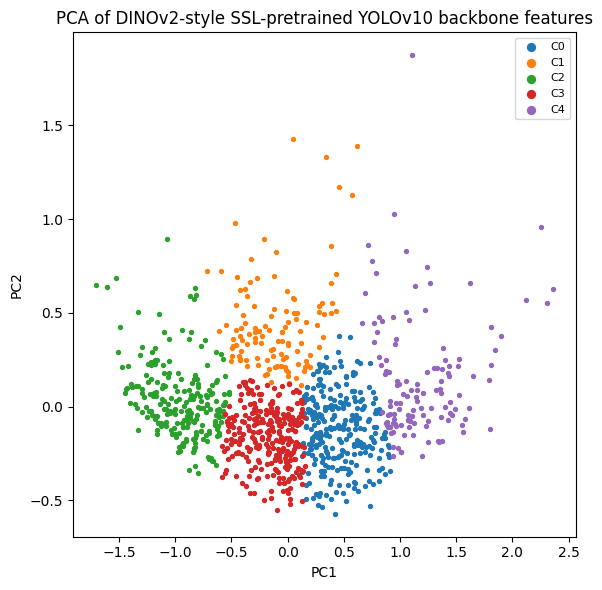

In [12]:
det_pca = YOLO("yolov10s.yaml")
det_pca.model.model[0].load_state_dict(torch.load(SSL_W, map_location="cpu"), strict=False)
bb = det_pca.model.model[0].to(device).eval()

class BBEnc(nn.Module):
    def __init__(self, bb): super().__init__(); self.bb=bb
    def forward(self, x):
        out = self.bb(x)
        t = _pick_last_feat(out)
        if t.ndim == 4:
            z = t.mean(dim=(2,3))
        elif t.ndim == 3:
            z = t.mean(dim=2)
        elif t.ndim == 2:
            z = t
        else:
            z = t.view(t.size(0), -1)
        return z

enc_pca = BBEnc(bb).to(device)
tfm_pca = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# sample images for PCA
IMG_DIRS = [SPLIT/"train/images", SPLIT/"valid/images"]
files=[]
for d in IMG_DIRS:
    if d.exists(): files += list(d.glob("*.*"))
random.shuffle(files)
files = files[:1000] if len(files)>1000 else files

feats=[]
with torch.no_grad():
    for p in files:
        try:
            img = Image.open(p).convert("RGB")
        except:
            continue
        x = tfm_pca(img).unsqueeze(0).to(device)
        z = enc_pca(x)
        feats.append(z.squeeze(0).cpu().numpy())
feats = np.stack(feats, axis=0)
print("PCA Feature matrix:", feats.shape)

pca = PCA(n_components=2, random_state=42)
xy = pca.fit_transform(feats)

k = 5
lab = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(feats)

plt.figure(figsize=(6,6))
for i in range(k):
    m = (lab==i)
    plt.scatter(xy[m,0], xy[m,1], s=8, label=f"C{i}")
plt.title("PCA of DINOv2-style SSL-pretrained YOLOv10 backbone features")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(markerscale=2, fontsize=8)
plt.tight_layout()
plt.show()


# Save YOLOv10 Model Result 

In [13]:
metrics = det.val(data=str(DATA), split="val")

results_dict = {
    "Method": "YOLO10-SSL",
    "Backbone": "DINOv2",
    "Parameters (M)": round(sum(p.numel() for p in det.model.parameters())/1e6, 2),
    "Precision": metrics.results_dict["metrics/precision(B)"],
    "Recall": metrics.results_dict["metrics/recall(B)"],
    "F1": (2 * metrics.results_dict["metrics/precision(B)"] * metrics.results_dict["metrics/recall(B)"]) /
          (metrics.results_dict["metrics/precision(B)"] + metrics.results_dict["metrics/recall(B)"] + 1e-9),
    "mAP@0.5": metrics.results_dict["metrics/mAP50(B)"],
    "mAP@0.95": metrics.results_dict["metrics/mAP50-95(B)"],
}

with open("results_yolo10.json", "w") as f:
    json.dump(results_dict, f, indent=4)

Ultralytics 8.3.184 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv10s summary (fused): 106 layers, 7,218,387 parameters, 0 gradients, 21.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2630.3±1103.2 MB/s, size: 2153.7 KB)


val: Scanning /kaggle/working/plastic_coco_ssl_yolov10_dinov2/yolo_split/valid/labels.cache... 742 images, 0 backgrounds, 0 corrupt: 100%|██████████| 742/742 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 93/93 [00:11<00:00,  8.03it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        742      23015      0.463      0.352      0.335      0.136
Speed: 0.3ms preprocess, 4.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/plastic_coco_ssl_yolov10_dinov2/ssl_yolov10s_dinov22
